In [1]:
# Standard Library
import os
import shutil
import time
import random
from io import BytesIO
from collections import defaultdict

# Data Handling
import numpy as np
import pandas as pd

# Image Processing
from PIL import Image
import PIL.ImageFile
PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Machine Learning & Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
SPLIT_PATH = '/kaggle/input/rgb-splitted-dataset/split_dataset.parquet'

In [3]:
df = pd.read_parquet(SPLIT_PATH)

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.5)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
class SignLanguageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        """
        Args:
            paths (list): List of image paths
            labels (list): List of corresponding labels
            transform (callable, optional): Optional transform to be applied
        """
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.classes = sorted(list(set(labels)))  # Get unique classes
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        
        # Convert label to index if it's not already numeric
        if isinstance(label, str):
            label = self.classes.index(label)
            
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [6]:
# Load data split dari parquet
df = pd.read_parquet(SPLIT_PATH)

# Pisahkan data berdasarkan split
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'val']
test_df = df[df['split'] == 'test']

# Buat dataset
train_dataset = SignLanguageDataset(
    paths=train_df['path'].tolist(),
    labels=train_df['label'].tolist(),
    transform=transform_train
)

val_dataset = SignLanguageDataset(
    paths=val_df['path'].tolist(),
    labels=val_df['label'].tolist(),
    transform=transform_val
)

test_dataset = SignLanguageDataset(
    paths=test_df['path'].tolist(),
    labels=test_df['label'].tolist(),
    transform=transform_test
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

In [8]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Load pretrained EfficientNetB0
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Freeze semua parameter
for param in model.parameters():
    param.requires_grad = False

# Unfreeze blok akhir (features[5] sampai [8])
for idx in range(5, 9):
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Ganti classifier (bagian akhir)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 31)  # 31 classes

# Pindahkan ke device
device = torch.device("cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 177MB/s]


In [9]:
# Menghitung jumlah total dan trainable parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

Total Parameters: 4,047,259
Trainable Parameters: 3,738,599


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5, patience=5)

In [11]:
num_epochs = 30
best_val_acc = 0.0

# List untuk menyimpan metrik
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

start_time = time.time()

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    train_correct, train_total = 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    # Hitung metrik training
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc = 100 * train_correct / train_total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    val_correct, val_total = 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    # Hitung metrik validation
    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = 100 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    # Update learning rate
    scheduler.step(epoch_val_loss)
    
    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        model_save_path = "/kaggle/working/best_efficient_model.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"✨ New best model saved with val_acc: {best_val_acc:.2f}%")

    
    # Print progress
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")
    print("-"*50)

print("\nTraining completed!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

end_time = time.time()
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print("\nTraining completed!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Total Training Time: {minutes} minutes {seconds} seconds")

✨ New best model saved with val_acc: 91.22%

Epoch 1/30
Train Loss: 1.1325 | Val Loss: 0.2921
Train Acc: 67.58% | Val Acc: 91.22%
--------------------------------------------------
✨ New best model saved with val_acc: 92.62%

Epoch 2/30
Train Loss: 0.3295 | Val Loss: 0.2413
Train Acc: 89.48% | Val Acc: 92.62%
--------------------------------------------------
✨ New best model saved with val_acc: 96.06%

Epoch 3/30
Train Loss: 0.2035 | Val Loss: 0.1676
Train Acc: 93.60% | Val Acc: 96.06%
--------------------------------------------------

Epoch 4/30
Train Loss: 0.1724 | Val Loss: 0.2072
Train Acc: 94.59% | Val Acc: 94.53%
--------------------------------------------------

Epoch 5/30
Train Loss: 0.1390 | Val Loss: 0.1606
Train Acc: 95.72% | Val Acc: 96.06%
--------------------------------------------------
✨ New best model saved with val_acc: 96.18%

Epoch 6/30
Train Loss: 0.1186 | Val Loss: 0.1432
Train Acc: 96.64% | Val Acc: 96.18%
--------------------------------------------------

E

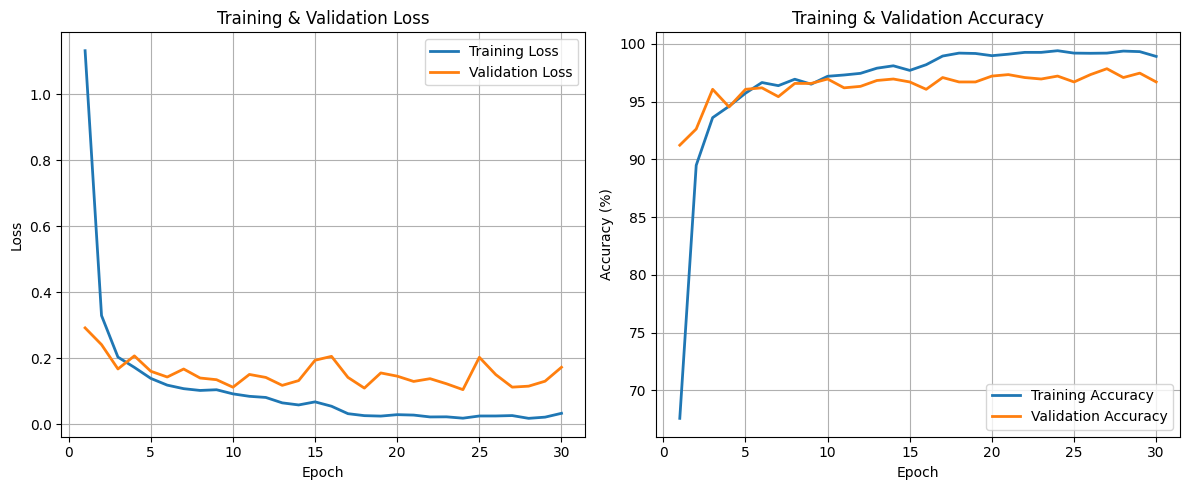

In [12]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', linestyle='-', linewidth=2)
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', linestyle='-', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', linestyle='-', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()  # Agar plot tidak tumpang tindih
plt.show()

/tmp/ipykernel_31/2657358877.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_efficient_model.pth"))



📊 Final Test Results:
Test Loss: 0.3091 | Test Accuracy: 97.07%

Classification Report:
              precision    recall  f1-score   support

          Ha       0.96      1.00      0.98        25
         ain       0.92      0.92      0.92        24
        alif       1.00      0.97      0.98        29
    alif_lam       0.97      1.00      0.98        28
          ba       0.97      0.97      0.97        31
         dal       0.92      0.96      0.94        23
        dhad       1.00      1.00      1.00        26
        dzal       1.00      0.95      0.97        20
          fa       0.86      0.96      0.91        26
       ghain       0.92      1.00      0.96        23
          ha       0.92      1.00      0.96        24
         jim       1.00      0.90      0.95        21
         kaf       0.96      1.00      0.98        26
         kha       1.00      0.92      0.96        25
         lam       1.00      1.00      1.00        26
    lam_alif       1.00      1.00      1.00   

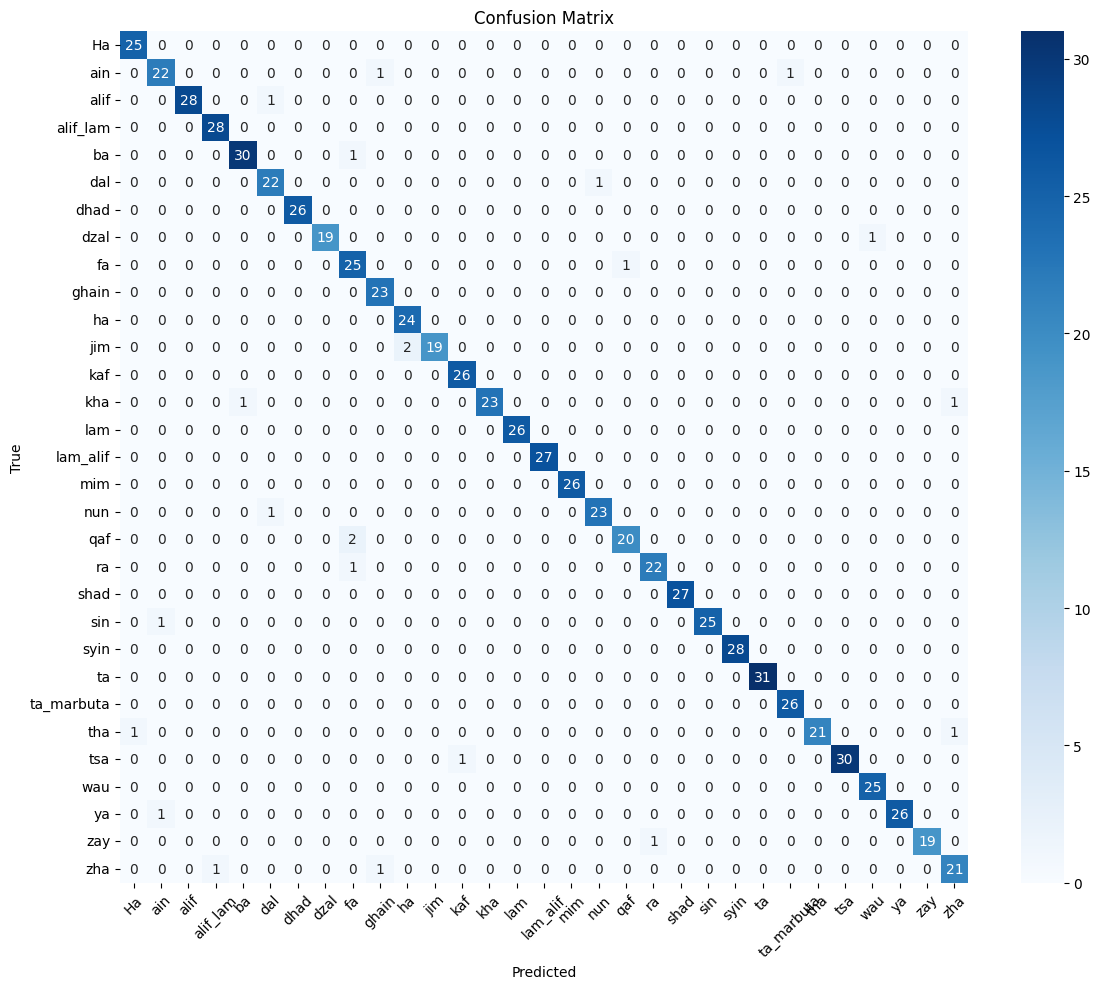


🎯 Akurasi Per Kelas:
Ha                  : 100.00%
ain                 : 91.67%
alif                : 96.55%
alif_lam            : 100.00%
ba                  : 96.77%
dal                 : 95.65%
dhad                : 100.00%
dzal                : 95.00%
fa                  : 96.15%
ghain               : 100.00%
ha                  : 100.00%
jim                 : 90.48%
kaf                 : 100.00%
kha                 : 92.00%
lam                 : 100.00%
lam_alif            : 100.00%
mim                 : 100.00%
nun                 : 95.83%
qaf                 : 90.91%
ra                  : 95.65%
shad                : 100.00%
sin                 : 96.15%
syin                : 100.00%
ta                  : 100.00%
ta_marbuta          : 100.00%
tha                 : 91.30%
tsa                 : 96.77%
wau                 : 100.00%
ya                  : 96.30%
zay                 : 95.00%
zha                 : 91.30%


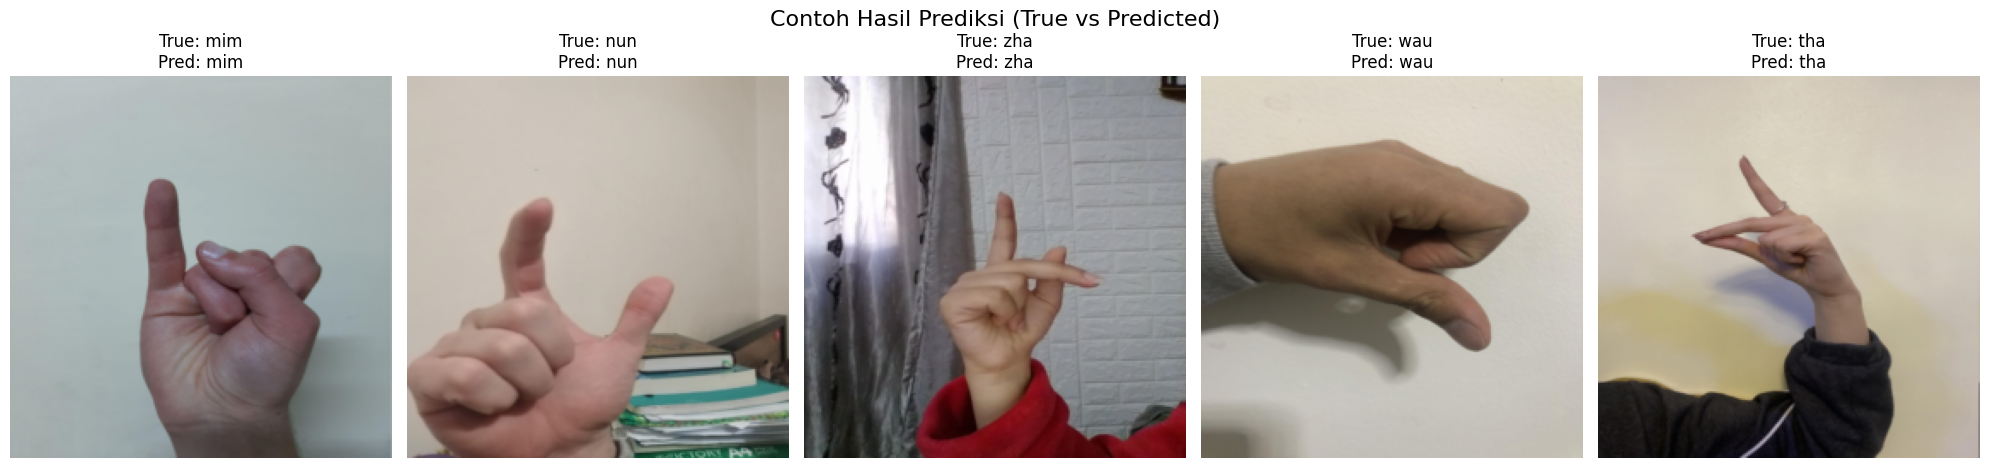

✅ Testing selesai! Hasil disimpan di: test_results.json


In [14]:
# 1. Load Model Terbaik
model.load_state_dict(torch.load("best_efficient_model.pth"))
model.eval()

# 2. Testing Loop
test_loss = 0.0
test_correct = 0
test_total = 0
all_preds = []
all_labels = []
test_progress = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Simpan beberapa sampel untuk visualisasi
        if len(test_progress) < 5:  # Ambil 5 sampel saja
            test_progress.append((images.cpu(), predicted.cpu(), labels.cpu()))

# 3. Hitung Metrik
test_accuracy = 100 * test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

# 4. Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n📊 Final Test Results:")
print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, zero_division=0))

# 5. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# 5.a Akurasi Per Kelas
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\n🎯 Akurasi Per Kelas:")
for idx, acc in enumerate(class_accuracy):
    print(f"{test_dataset.classes[idx]:<20}: {acc * 100:.2f}%")

# 6. Visualisasi Beberapa Hasil Prediksi
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Contoh Hasil Prediksi (True vs Predicted)', fontsize=16)

for idx, (images, preds, labels) in enumerate(test_progress):
    img = images[0].permute(1, 2, 0).numpy()
    img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)
    
    axes[idx].imshow(img)
    axes[idx].set_title(f"True: {test_dataset.classes[labels[0]]}\nPred: {test_dataset.classes[preds[0]]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png')
plt.show()

# 7. Save Hasil Testing
results = {
    'test_loss': avg_test_loss,
    'test_accuracy': test_accuracy,
    'classification_report': classification_report(all_labels, all_preds, output_dict=True),
    'confusion_matrix': cm.tolist(),
    'per_class_accuracy': {
        test_dataset.classes[i]: round(acc * 100, 2)
        for i, acc in enumerate(class_accuracy)
    }
}

import json
with open('test_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("✅ Testing selesai! Hasil disimpan di: test_results.json")


In [15]:
pip install torchprofile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.

In [16]:
# 1. Hitung Ukuran Model
def print_model_size(model):
    torch.save(model.state_dict(), "temp_model.pth")
    model_size = os.path.getsize("temp_model.pth") / (1024 * 1024)  # dalam MB
    os.remove("temp_model.pth")
    print(f"📦 Model Size: {model_size:.2f} MB")

print_model_size(model)

# 2. Hitung Inference Speed
def measure_inference_speed(model, test_loader, device, n_runs=100):
    model.eval()
    dummy_input = next(iter(test_loader))[0][0].unsqueeze(0).to(device)
    
    # Warm-up
    for _ in range(10):
        _ = model(dummy_input)
    
    # Benchmark
    start_time = time.time()
    for _ in range(n_runs):
        with torch.no_grad():
            _ = model(dummy_input)
    end_time = time.time()
    
    avg_time = (end_time - start_time) * 1000 / n_runs  # dalam milidetik
    fps = 1000 / avg_time  # frame per second
    print(f"⏱️ Inference Speed: {avg_time:.2f} ms per sample ({fps:.2f} FPS)")
    return avg_time

# Gunakan 100 sampel acak untuk pengukuran
avg_inference_time = measure_inference_speed(model, test_loader, device)

# 3. Hitung FLOPs (Opsional)
from torchprofile import profile_macs  # pip install torchprofile

def calculate_flops(model, input_size=(1, 3, 224, 224)):
    dummy_input = torch.randn(input_size).to(device)
    macs = profile_macs(model, dummy_input)
    flops = 2 * macs  # 1 MAC ≈ 2 FLOP
    print(f"🧮 FLOPs: {flops / 1e9:.2f} GFLOPs")
    return flops

try:
    flops = calculate_flops(model)
except Exception as e:
    print(f"⚠️ Tidak bisa menghitung FLOPs: {str(e)}")

📦 Model Size: 15.72 MB
⏱️ Inference Speed: 37.19 ms per sample (26.89 FPS)
🧮 FLOPs: 0.79 GFLOPs


/usr/local/lib/python3.11/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::silu_". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
